# <b>OceanParcels in CNRM-CM6 models</b>

[OceanParcels website](https://oceanparcels.org/)

In this notebook, I'll guide you to start a very simplified simulation of virtual particles in CNRM-CM6 models. Most of this tutorial has been written with the help of to the various [tutorials](https://docs.oceanparcels.org/en/latest/documentation.html) available on OceanParcels website, I strongly recommend you to go check them. Also, the developpers are very active on their [GitHub](https://github.com/OceanParcels/parcels), if you run into a bug you don't know how to solve, check first in the [discussions](https://github.com/OceanParcels/parcels/discussions) section, someone may already have run into the similar bug, otherwise start a discussion there!

## Install Parcels

The first step if of course to install the parcels environment, I would recommend to follow the steps explained [here](https://docs.oceanparcels.org/en/latest/installation.html). As you will most probably have to install a new `conda` environment, do not forget to install all the modules you might need for running your jobs

Once it's done, `import` the parcels package and the relevant modules for this tutorial:

In [1]:
from parcels import FieldSet, JITParticle, Variable, ParticleSet, AdvectionRK4_3D
import numpy as np
from datetime import timedelta as delta
import xarray as xr
import pylab as plt
import cartopy.crs as ccrs

/localscratch/estebav.25392386.0/lib/python3.10/site-packages/pyproj/__init__.py:91: UserWarning: Valid PROJ data directory not found. Either set the path using the environmental variable PROJ_LIB or with `pyproj.datadir.set_data_dir`.
  warnings.warn(str(err))


## 1. FieldSet

To start a parcels simulation, we must first define an existing flow field environment with the `FieldSet` class. Minimal requirements for this FieldSet are that it must contain the `U` and `V` fields. Here, we will also include `W` as we are interested in 3D advection, as well as `T` (temperature) and `S` (salinity).

This function requires `filenames`, `variables`, and `dimensions`.

Let's locate the files of interest and to store their paths:

In [2]:
fileMesh = '/project/ctb-cdufour/estebav/CNRM-CM6/AntarcticExclusion/eORCA1_mesh_mask_Extracted.nc'

fileU = '/project/ctb-cdufour/estebav/CNRM-CM6/AntarcticExclusion/uo_Omon_CNRM-CM6-1_piControl_r1i1p1f2_gn_185001-189912_Extracted.nc'
fileV = '/project/ctb-cdufour/estebav/CNRM-CM6/AntarcticExclusion/vo_Omon_CNRM-CM6-1_piControl_r1i1p1f2_gn_185001-189912_Extracted.nc'
fileW = '/project/ctb-cdufour/estebav/CNRM-CM6/AntarcticExclusion/wo_Omon_CNRM-CM6-1_piControl_r1i1p1f2_gn_185001-189912_Extracted.nc'
fileT = '/project/ctb-cdufour/estebav/CNRM-CM6/AntarcticExclusion/thetao_Omon_CNRM-CM6-1_piControl_r1i1p1f2_gn_185001-189912_Extracted.nc'
fileS = '/project/ctb-cdufour/estebav/CNRM-CM6/AntarcticExclusion/so_Omon_CNRM-CM6-1_piControl_r1i1p1f2_gn_185001-189912_Extracted.nc'

This is quite straightforward as I only use one set of files. If you have to give Parcels more than one file for each variable, you have to create an **ordered list** with the paths to the files of interest, as shown [here](https://docs.oceanparcels.org/en/latest/examples/tutorial_nemo_3D.html). Also, the meshfile may not contain any `NaN`, Parcels would reject a grid file with `NaN` values for the continents for example.

First, to point out to the model outputs paths we just defined, we have to fill in `filenames`:

In [3]:
filenames = {
    'U': {'lon': fileMesh, 'lat': fileMesh, 'depth': fileW, 'data': fileU},
    'V': {'lon': fileMesh, 'lat': fileMesh, 'depth': fileW, 'data': fileV},
    'W': {'lon': fileMesh, 'lat': fileMesh, 'depth': fileW, 'data': fileW},
    'T': {'lon': fileMesh, 'lat': fileMesh, 'depth': fileW, 'data': fileT},
    'S': {'lon': fileMesh, 'lat': fileMesh, 'depth': fileW, 'data': fileS},
}

Second, we have to specify the variable names as given by the NetCDF files, we fill in `variables`:

In [4]:
variables = {
    'U': 'uo',
    'V': 'vo',
    'W': 'wo',
    'T': 'thetao',
    'S': 'so',
}

Third, we specify the names of the variable dimensions, again, as given by the NetCDF files. For the C-grid interpolation to work properly in Parcels, it is important that `U`, `V`, and `W` are on the same grid. Parcels needs to read the f-nodes (corners of each cell) to interpolate correctly. Note thate on a C-grid, all variables need the same `dimensions`:

In [5]:
dimensions = {
    'U': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'lev', 'time': 'time'},
    'V': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'lev', 'time': 'time'},
    'W': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'lev', 'time': 'time'},
    'T': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'lev', 'time': 'time'},
    'S': {'lon': 'glamf', 'lat': 'gphif', 'depth': 'lev', 'time': 'time'},
}

Finally, we load the fieldset:

In [6]:
fieldset = FieldSet.from_nemo(filenames, variables, dimensions)

Also worth to know, if you want to run a simulation longer than the model' outputs you stored, and looping over the files you just mentioned for creating the fieldset, you can just add `allow_time_extrapolation=True` to the arguments of `Fieldset.from_nemo()`

## 2. ParticleSet

Once the environment has a `FieldSet` object, we can start defining our particles in a `ParticleSet` object. It requires:
- the `FieldSet` object in which the particles are released
- the type of `Particle`: Either  a `JITParticle` or `ScipyParticle`
- Initial conditions for each `Variable` defined in the `Particle`, most notably the release locations in `lon` and `lat`

This is where it gets interesting, this class is where we will create particles' specific variables (later to be filled in by kernels, but don't be impatient, we will come to that in a minute). Cutting a long story short: JIT is faster than Scipy (if you want to know why click [here](https://docs.oceanparcels.org/en/latest/examples/tutorial_jit_vs_scipy.html)). Let's create the `Particle` and its variables, we here will track its velocity field, temperature, salt, and age:



In [7]:
class oceanParticle(JITParticle):
    uVel = Variable('uVel', dtype=np.float32, initial=np.nan)
    vVel = Variable('vVel', dtype=np.float32, initial=np.nan)
    wVel = Variable('wVel', dtype=np.float32, initial=np.nan)
    theta = Variable('theta', dtype=np.float32, initial=np.nan)
    salt = Variable('salt', dtype=np.float32, initial=np.nan)
    age = Variable('age', dtype=np.float32, initial=0.)

Also, if you want to store a time-independent variable for the particle (for example a certain particle area), you can use the argument `to_write='once'`:
```
area = Variable('area', dtype=np.float32, to_write='once', initial=0.)
```

We have to choose from where we release the particles. Let's do a simple example here and release them in the Atlantic Ocean at 20&deg;N, between 20 and 40&deg;W, and from the 100 to 1000 m deep. Something not to forget, the shapes of the zonal, latitudinal and depth extents of the injection 'box' have to be identical:

In [8]:
lonStart = -40
latStart = 20
lonEnd = -20
latEnd = 20

depthStart = 100
depthEnd = 1000

nmbH = 21 # seed every degree horizontally
nmbV = 51 # seed every 18 meters vertically

if lonStart == lonEnd:
    Lats = np.repeat(np.linspace(latStart, latEnd, nmbH), nmbV)
    Lons = np.repeat(np.full(nmbH, lonStart), nmbV)
else:
    Lats = np.repeat(np.full(nmbH, latStart), nmbV)
    Lons = np.repeat(np.linspace(lonStart, lonEnd, nmbH), nmbV)

Depths = np.array([np.linspace(depthStart, depthEnd, 51) for i in range(nmbH)]).reshape((nmbH*nmbV))

Everything set! we can define our `ParticleSet`:

In [9]:
pset = ParticleSet(
    fieldset=fieldset,
    pclass=oceanParticle,
    lon=Lons,
    lat=Lats,
    depth=Depths,
)

As I show you a simple example here, I do not inject multiple times during the simulation but only once. However, if you wish to repreat the injections every week for example, add this argument to `ParticleSet()`:

```
repeatdt=delta(weeks=1)
```

Other alternatives for injecting at different times are also listed [here](https://docs.oceanparcels.org/en/latest/examples/tutorial_delaystart.html).

You can verify quickly your `ParticleSet` by printing it, Let's show the first 10 elements:

In [10]:
for i in range(10):
    print(pset[i])

P[0](lon=-40.000000, lat=20.000000, depth=100.000000, uVel=nan, vVel=nan, wVel=nan, theta=nan, salt=nan, age=0.000000, time=not_yet_set)
P[1](lon=-40.000000, lat=20.000000, depth=118.000000, uVel=nan, vVel=nan, wVel=nan, theta=nan, salt=nan, age=0.000000, time=not_yet_set)
P[2](lon=-40.000000, lat=20.000000, depth=136.000000, uVel=nan, vVel=nan, wVel=nan, theta=nan, salt=nan, age=0.000000, time=not_yet_set)
P[3](lon=-40.000000, lat=20.000000, depth=154.000000, uVel=nan, vVel=nan, wVel=nan, theta=nan, salt=nan, age=0.000000, time=not_yet_set)
P[4](lon=-40.000000, lat=20.000000, depth=172.000000, uVel=nan, vVel=nan, wVel=nan, theta=nan, salt=nan, age=0.000000, time=not_yet_set)
P[5](lon=-40.000000, lat=20.000000, depth=190.000000, uVel=nan, vVel=nan, wVel=nan, theta=nan, salt=nan, age=0.000000, time=not_yet_set)
P[6](lon=-40.000000, lat=20.000000, depth=208.000000, uVel=nan, vVel=nan, wVel=nan, theta=nan, salt=nan, age=0.000000, time=not_yet_set)
P[7](lon=-40.000000, lat=20.000000, depth

## 3. Kernels

This is where most of the magic happens, Kernels! Basically they are little snippets of code, which are applied to every particle in the `ParticleSet`, for every time step during a simulation. The basic ones are [included in Parcels](https://docs.oceanparcels.org/en/latest/reference/predefined_kernels.html#predefined-kernels), for example here to advect the particles in 3D, we will make use of the `AdvectionRK4_3D` predefined kernel.

But one can also write custom kernels to add certain types of 'behaviour' to the particles. Kernels can then be combined with the `+` operator, or by creating a `list` of them. Important to note, they are executed in order. In this example we will create a kernel keeping track of the particle age (in days):

In [11]:
def Age(particle, fieldset, time):
    if particle.time > 0:
        particle.age += particle.dt/86400.

As well as one sampling `U`, `V`, `W`, `T`, and `S` along the particle trajectory. Something worth to know, when sampling velocities Parcels converts them to &deg; s⁻¹. But we want to sample our velocities in m s⁻¹ right? The most straightforward way to do it is just by telling Parcels not to convert them like this:

In [12]:
def SampleVars(particle, fieldset, time):
    (particle.uVel, particle.vVel, particle.wVel) = fieldset.UVW.eval(time, particle.depth, particle.lat, particle.lon, particle, applyConversion=False)
    particle.theta = fieldset.T[time, particle.depth, particle.lat, particle.lon]
    particle.salt = fieldset.S[time, particle.depth, particle.lat, particle.lon]

But of course, if you sample the velocities in a kernel that **displaces** your particle, apply the conversion and sample them like that:
```
(particle.uVel, particle.vVel, particle.wVel) = fieldset.UVW[time, particle.depth, particle.lat, particle.lon, particle]
```

We finish by adding the kernels we want to use to each other:

In [13]:
kernels = pset.Kernel(Age) + pset.Kernel(SampleVars) + pset.Kernel(AdvectionRK4_3D)

Some key limitations exist to Kernels, I suggest you to check [*3. Kernels*](https://docs.oceanparcels.org/en/latest/examples/tutorial_parcels_structure.html) to be sure not to do anything wrong and to get what you expect from them.

## 4. Execution and output

This final part executes the simulation, given the `FieldSet`, `ParticleSet`, and `Kernels`, that have been defined in the previous steps. As we want to store the particle data generated in the simulation, we define a `ParticleFile` to which the output of the kernels execution will be written. Following choices have to be made:
- `name` of the output file
- `outputdt` is the time period between consecutive output steps
- `chunks` determines the chunking of the output file (very useful when doing long runs with a lot of particles, here not worth it so I commented it)

In [14]:
outputFile = pset.ParticleFile(
    '/project/ctb-cdufour/estebav/CNRM-CM6/test1.zarr',
    outputdt=delta(days=5),
    #chunks=(100, 100),
)

Then, on the `ParticleSet` we have defined, we can use the method `ParticleSet.execute()` requiring the following arguments:
- kernels ot be executed
- `runtime` defines how long the execution loop runs. Alternatively, you may define the `endtime` at which the execution loop stops
- the timestep `dt` at which to execute the kernels (<b><font color="green">positive</font></b> if you want to track the particles <b><font color="green">forward in time</font></b>, <b><font color="red">negative</font></b> if you want to track the particles <b><font color="red">backward in time</font></b>
)
- the `output_file` where it writes the outputs

In [15]:
pset.execute(
    kernels,
    runtime=delta(days=2*365),
    dt=delta(days=1),
    output_file=outputFile,
)

INFO: Output files are stored in /project/ctb-cdufour/estebav/CNRM-CM6/test1.zarr.
100%|██████████| 63072000.0/63072000.0 [01:23<00:00, 756697.76it/s] 


## 5. Reading Parcels outputs

Parcels exports output trajectories in `zarr` format. The good thing is that these files are *much* smaller in size than `netcdf`, the bad thing is that it generates an enormous amount of files. For small runs as this one it is okay to keep it in `zarr` format, but I strongly recommend to convert it to a `netcdf` if your file number limit is more restrictive than your storage limit. I'll show you some lines of code in the *Tips and tricks* section in order to do so.

So, back to our `zarr` file, `xarray` has a wonderful `open_zarr()` method:

In [16]:
dataTest1 = xr.open_zarr('/project/ctb-cdufour/estebav/CNRM-CM6/test1.zarr')
dataTest1

<xarray.Dataset>
Dimensions:     (trajectory: 1071, obs: 146)
Coordinates:
  * obs         (obs) int32 0 1 2 3 4 5 6 7 ... 138 139 140 141 142 143 144 145
  * trajectory  (trajectory) int64 0 1 2 3 4 5 ... 1065 1066 1067 1068 1069 1070
Data variables:
    age         (trajectory, obs) float32 dask.array<chunksize=(1071, 1), meta=np.ndarray>
    lat         (trajectory, obs) float64 dask.array<chunksize=(1071, 1), meta=np.ndarray>
    lon         (trajectory, obs) float64 dask.array<chunksize=(1071, 1), meta=np.ndarray>
    salt        (trajectory, obs) float32 dask.array<chunksize=(1071, 1), meta=np.ndarray>
    theta       (trajectory, obs) float32 dask.array<chunksize=(1071, 1), meta=np.ndarray>
    time        (trajectory, obs) datetime64[ns] dask.array<chunksize=(1071, 1), meta=np.ndarray>
    uVel        (trajectory, obs) float32 dask.array<chunksize=(1071, 1), meta=np.ndarray>
    vVel        (trajectory, obs) float32 dask.array<chunksize=(1071, 1), meta=np.ndarray>
    wVel        (trajectory, obs) float32 dask.array<chunksize=(1071, 1), meta=np.ndarray>
    z           (trajectory, obs) float64 dask.array<chunksize=(1071, 1), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        oceanParticleAgeSampleVarsAdvectionRK4_3D
    parcels_mesh:           spherical
    parcels_version:        3.0.2

As you can see, the data is stored in a **two-dimensional array** with the dimensions `traj` and `obs`. Basically, each particle trajectory is stored as a time series where the coordinate data (`lon`, `lat`, `z`, `time`) are a function of the observation (`obs`). Here, the output dataset contains **1071 particles** and **74 observations** 

## 6. Plotting

I personally use `cartopy` for plotting as it is compatible with `matplotlib`, but you are free to use any other map-drawing tool.

The default way matplotlib plots 2D arrays is to plot a separate set for each column. But in Parcels the columns correspond to the `obs` dimension, so to separate the different trajectories we need to **transpose** the 2D array using `.T`:

In [17]:
xCoords = dataTest1['lon'].T
yCoords = dataTest1['lat'].T

It is then possible to plot the particle trajectories!

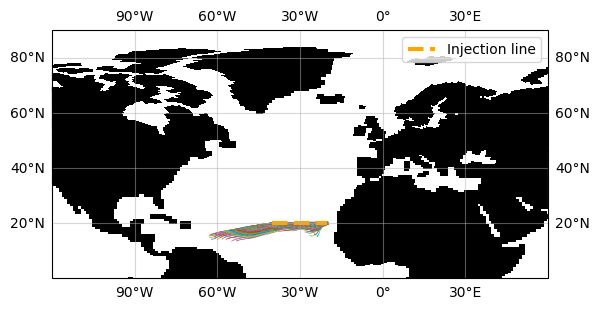

In [18]:
dsMesh = xr.open_dataset('/project/ctb-cdufour/estebav/CNRM-CM6/eORCA1_mesh_mask.nc')
    
glamf = dsMesh['glamf'].squeeze()
gphif = dsMesh['gphif'].squeeze()
fMask = dsMesh['fmask'][0, 0, ...]
landMask = (fMask.where(fMask == 0, other=1))

if lonStart == lonEnd:
    latsInj = np.arange(latStart, latEnd+1)
    lonsInj = np.full(latsInj.shape, lonStart)
else:
    lonsInj = np.arange(lonStart, lonEnd+1)
    latsInj = np.full(lonsInj.shape, latStart)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.plot(xCoords, yCoords, '-', transform=ccrs.PlateCarree(), linewidth=0.5)
ax.plot(lonsInj, latsInj, '--', transform=ccrs.PlateCarree(), linewidth=3, color='orange', label='Injection line')
ax.pcolormesh(glamf, gphif, landMask, cmap='binary_r', transform=ccrs.PlateCarree())
ax.legend()
ax.gridlines(draw_labels=True, alpha=0.5)
ax.set_extent([-120, 60, 0, 90], crs=ccrs.PlateCarree())

## 7. Tips and tricks

### 7.1. ```ThroughSurfaceError```

If you seed particles from the very surface you might encounter the following error:
```
ThroughSurfaceError: 0
Particle P[0](lon=-40.000000, lat=20.000000, depth=0.000000, uVel=nan, vVel=nan, wVel=nan, theta=nan, salt=nan, age=0.000000, time=0.000000)
Time: 1850-01-16T12:00:00.000000000
timestep dt: 86400.0
Through-surface sampling by particle at (-40.0, 20.0, 0.0)
```

This is triggered when a particle "jumps" out of the domain (in this case most probably because `W` was positive at the first depth level). Various solutions can be applied: either terminate the particle or push it back within the ocean. Killing the advection of the particle is very easy, you can just add this `Kernel` to your list, preferably at the very beginning:

```
def AboveSurface(particle, fieldset, time):
    if particle.state == StatusCode.ErrorThroughSurface:
        particle.delete()
```

Note that you need to import `StatusCode` from `parcels` in order to use it. The advection of the particle will be stopped and this will allow your job to continue without crashing the whole simulation because of a single particle misbehaving. If you just want to push it back, you can use a similar `Kernel` and add it to your list, again, preferably at the very beginning:

```
def KeepInOcean(particle, fieldset, time):
     if particle.state == StatusCode.ErrorThroughSurface:
        particle_ddepth = 0.0
        particle.state = StatusCode.Success
```

This will push the particle back to the surface, again, preventing your job to crash needlessly

### 7.2. ```OutOfBoundsError```

This error is triggered if a particle crosses the boundaries of your domain, this might happen if you work with a cropped domain, or that you did not implement periodic boundaries (normally not needed with nemo grid, click [here](https://docs.oceanparcels.org/en/latest/examples/tutorial_periodic_boundaries.html) to know why). Here's an example:

```
OutOfBoundsError: 0
Particle P[0](lon=-40.000000, lat=20.000000, depth=100.000000, uVel=nan, vVel=nan, wVel=nan, theta=nan, salt=nan, age=0.000000, time=0.000000)
Time: 1850-01-16T12:00:00.000000000
timestep dt: 86400.0
Out-of-bounds sampling by particle at (-40.0, 20.0, 100.0)
```

The most straightforward method is to stop the advection of the particle if the error is triggered, preventing the job to crash:

```
def CheckOutOfBounds(particle, fieldset, time):
    if particle.state == StatusCode.ErrorOutOfBounds:
        particle.delete()
```

### 7.3. Converting `zarr` to `netcdf`

Chunking is one way to reduce the number of files, memory used, and weight of your output files (see in *4. Execution and output*). However, at the end of the simulation, it is possible to convert the `zarr` to a `netcdf` file, and to delete the now useless `zarr` output file. Here is what I do:

```
ds = xr.open_zarr(savename+'.zarr')
ds.to_netcdf(savename+'.nc')
# Check whether the netcdf file was created before the zarr file is deleted
if os.path.isfile(savename+'%i'%yr+'.nc'):
    shutil.rmtree(savename+'%i'%yr+'.zarr')
```